# NLP EDA

Basically, exploration and modeling boil down to a single question:

How do we quantify our data/text

In this lesson, we'll explore answers to this question that will aid in visualization.

- word frequency (by label)
- ngrams
- word cloud
- sentiment analysis
- other common features

## Setup

Data is spam/ham text messages.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re

In [32]:
# setting basic style parameters for matplotlib
# plt.rc('figure', figsize=(13, 7))
# plt.style.use('seaborn-v0_8')

In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
# basic cleaning function:
# ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

# def clean(text):
#     '''Simplified text cleaning function'''
#     stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
#     text = text.lower()
#     text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
#     words = re.sub(r"[^a-z0-9\s]", '', text)
#     return [word for word in words if word not in stopwords]

In [5]:
# acquire data from spam_db

from env import username, password, host

def get_db_url(database, host=host, user=username, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url)
df.head()

,id,label,text
0,0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Ci..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 t...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_validate, test = train_test_split(df, random_state = 1349, train_size=.8, stratify=df.label)

train, validate = train_test_split(train_validate, random_state = 1349, train_size=.7, stratify=train_validate.label)

### If we look at this in the context of a classification problem,
we may ask:
 - What leads to a spam text?
 - What leads to a ham text?
 

In [8]:
ham_df = train[train.label == 'ham']

In [9]:
ham_words = clean(' '.join(train[train.label == 'ham']['text']))

In [10]:
spam_words = clean(' '.join(train[train.label == 'spam']['text']))
all_words = clean(' '.join(train['text']))

In [11]:
# let's get some sights on word frequency by taking our words back apart
# we will split each set of words by the spaces,
# turn that into a list, cast that list as a Series,
# and then take the value counts of that Series
# We will do this for each type of word present
len(ham_words), len(spam_words), len(all_words)

(21681, 6815, 28496)

In [12]:
len(ham_words) + len(spam_words) == len(all_words)

True

In [13]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [14]:
ham_freq.head()

im      254
get     198
ok      158
go      148
know    142
dtype: int64

In [15]:
spam_freq.head()

call    195
free    126
text     84
ur       81
txt      76
dtype: int64

In [16]:
all_freq.head()

call    320
im      262
get     243
ur      202
4       175
dtype: int64

In [17]:
all_freqs = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)
all_freqs.columns = ['ham', 'spam', 'all']

In [18]:
all_freqs.head(20)

,ham,spam,all
im,254,8,262
get,198,45,243
ok,158,3,161
go,148,20,168
know,142,16,158
dont,141,13,154
come,138,4,142
like,127,9,136
day,126,15,141
call,125,195,320


## Exploration

Represent text as word frequencies.

In [19]:
# concat all frequencies together into a dataframe

- What are the most frequently occuring words?
- Are there any words that uniquely identify a spam or ham message? I.e. words present in one type of message but not the other?

In [20]:
all_freqs.sort_values('spam', ascending=False)

,ham,spam,all
call,125,195,320
free,31,126,157
text,43,84,127
ur,121,81,202
txt,7,76,83
...,...,...,...
cuddling,1,0,1
shijutta,1,0,1
ultimately,1,0,1
tor,1,0,1


In [21]:
all_freqs.sort_values(['ham', 'spam', 'all'], ascending=False).head()

,ham,spam,all
im,254,8,262
get,198,45,243
ok,158,3,161
go,148,20,168
know,142,16,158


### Visualization

- ham vs spam count for 20 most common words
- ham vs spam proportion for 20 most common words

<AxesSubplot:>

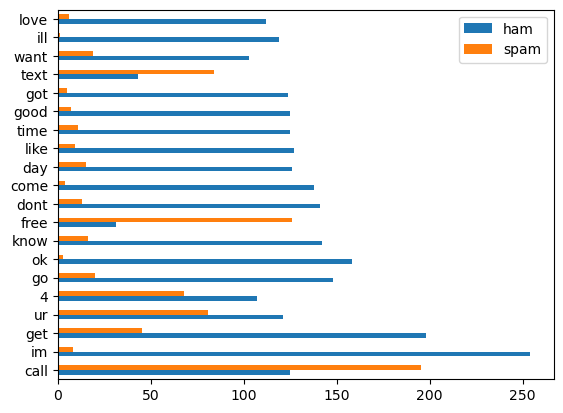

In [22]:
all_freqs.sort_values('all', ascending=False)[['ham', 'spam']].head(20).plot.barh()

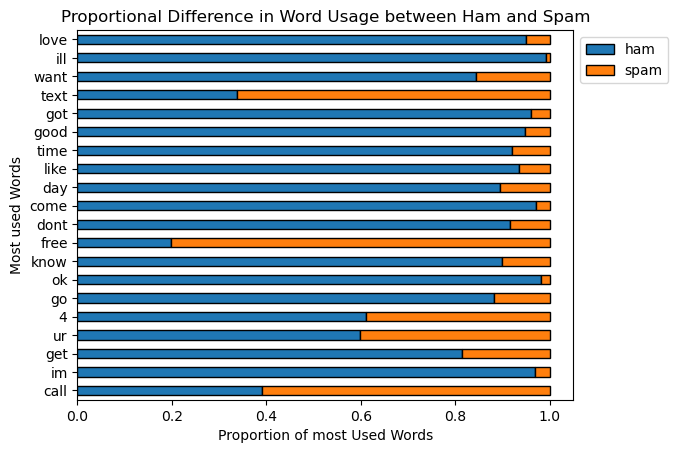

In [23]:
all_freqs.sort_values('all', ascending=False).head(20).apply(lambda row: row/row['all'], axis=1)[['ham', 'spam']]\
.plot.barh(stacked=True, ec='black')
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Proportional Difference in Word Usage between Ham and Spam')
plt.xlabel('Proportion of most Used Words')
plt.ylabel('Most used Words')
plt.show()

## n-grams

**bigram**: combinations of 2 words

Represent text as combinations of 2 words

**Be Careful!** Make sure you are making bigrams out of *words*.

- what are the most common bigrams? spam bigrams? ham bigrams?
- visualize 20 most common bigrams, most common ham bigrams
- ngrams

Find the most common bigram and then find a representative text

In [24]:
some_string = 'here is a thing to use in our bigrams ok'

In [25]:
list(nltk.bigrams(some_string.split()))

[('here', 'is'),
 ('is', 'a'),
 ('a', 'thing'),
 ('thing', 'to'),
 ('to', 'use'),
 ('use', 'in'),
 ('in', 'our'),
 ('our', 'bigrams'),
 ('bigrams', 'ok')]

In [26]:
ham_words

['er',
 'hello',
 'thing',
 'didnut',
 'quite',
 'go',
 'plan',
 'uo',
 'limping',
 'slowly',
 'home',
 'followed',
 'aa',
 'exhaust',
 'hanging',
 'still',
 'around',
 'could',
 'use',
 'half8th',
 'anything',
 'lor',
 'go',
 'go',
 'lor',
 'watching',
 'tv',
 'got',
 'new',
 'job',
 'slept',
 'timeyou',
 'compliment',
 'away',
 'system',
 'side',
 'right',
 'though',
 'cant',
 'give',
 'space',
 'want',
 'need',
 'really',
 'starting',
 'become',
 'issue',
 'going',
 'suggest',
 'setting',
 'definite',
 'move',
 'outif',
 'im',
 'still',
 'greece',
 'maybe',
 'ready',
 'hi',
 'baby',
 'im',
 'cruisin',
 'girl',
 'friend',
 'give',
 'call',
 'hour',
 'home',
 'thats',
 'alright',
 'fone',
 'fone',
 'love',
 'jenny',
 'xxx',
 'yeah',
 'ill',
 'leave',
 'couple',
 'minute',
 'amp',
 'let',
 'know',
 'get',
 'mu',
 'im',
 'still',
 'looking',
 'car',
 'buy',
 'gone',
 '4the',
 'driving',
 'test',
 'yet',
 'cool',
 'let',
 'know',
 'kick',
 'around',
 'ill',
 'day',
 'babe',
 'lost',
 'tr

<AxesSubplot:>

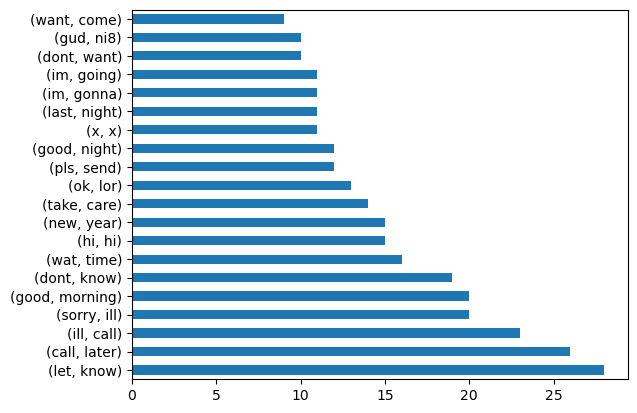

In [30]:
pd.Series(nltk.bigrams(ham_words)).value_counts().head(20).plot.barh()

<AxesSubplot:>

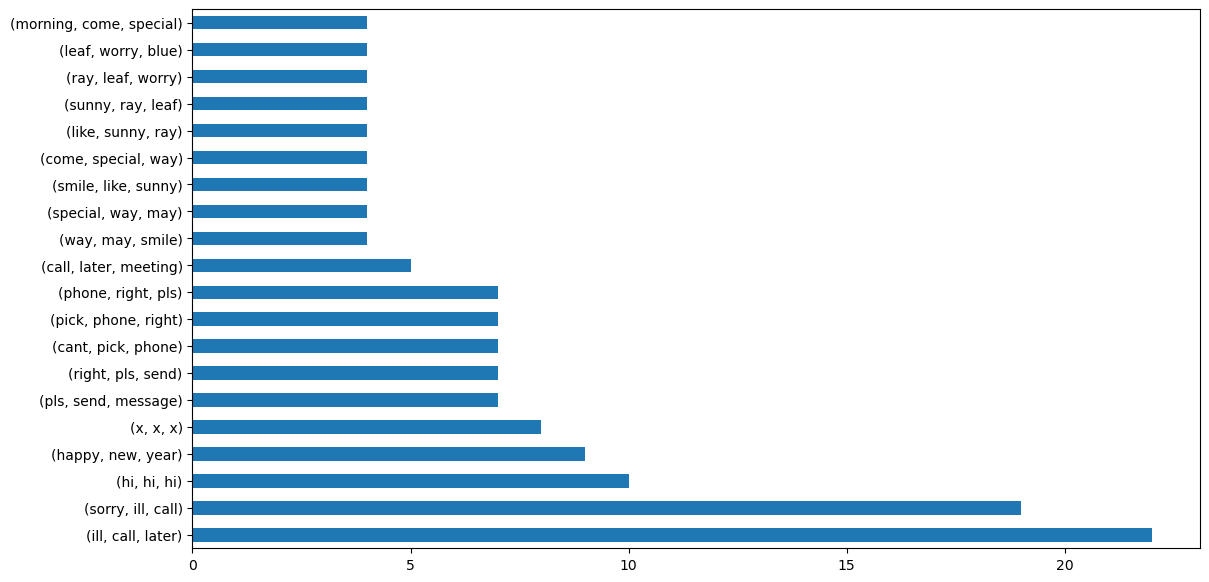

In [38]:
pd.Series(nltk.ngrams(ham_words, 3)).value_counts().head(20).plot.barh()

<AxesSubplot:>

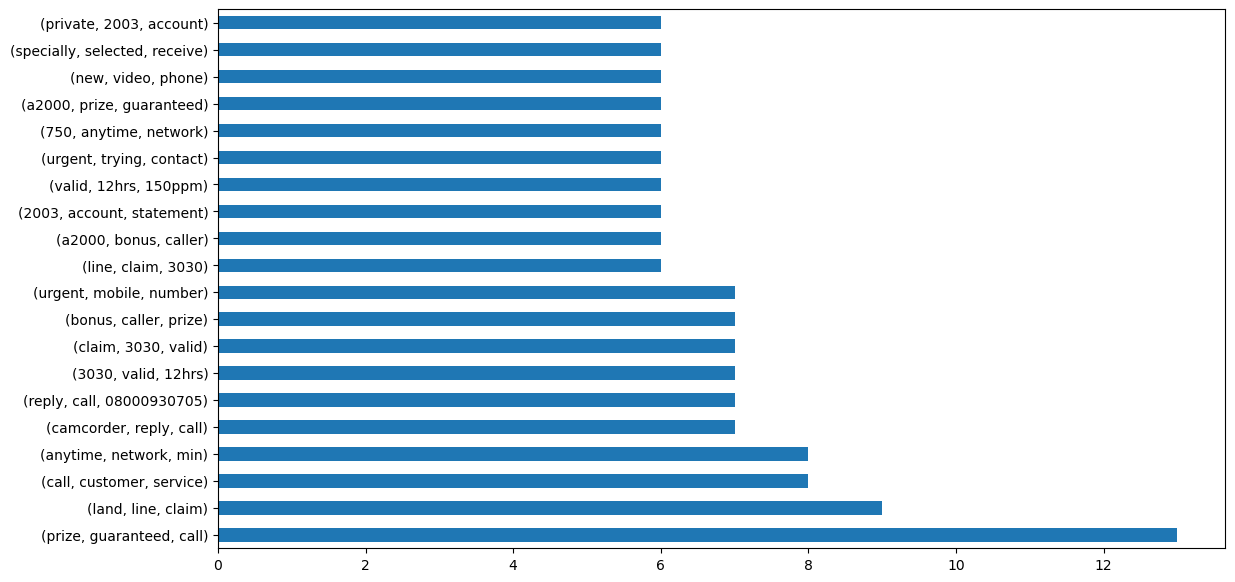

In [37]:
pd.Series(nltk.ngrams(spam_words, 3)).value_counts().head(20).plot.barh()

## Word Cloud

`python -m pip install --upgrade wordcloud`

documentation: https://amueller.github.io/word_cloud/

In [39]:
from wordcloud import WordCloud

In [40]:
# WordCloud expects a single string

img = WordCloud(background_color='White', ).generate(' '.join(ham_words))

In [41]:
img

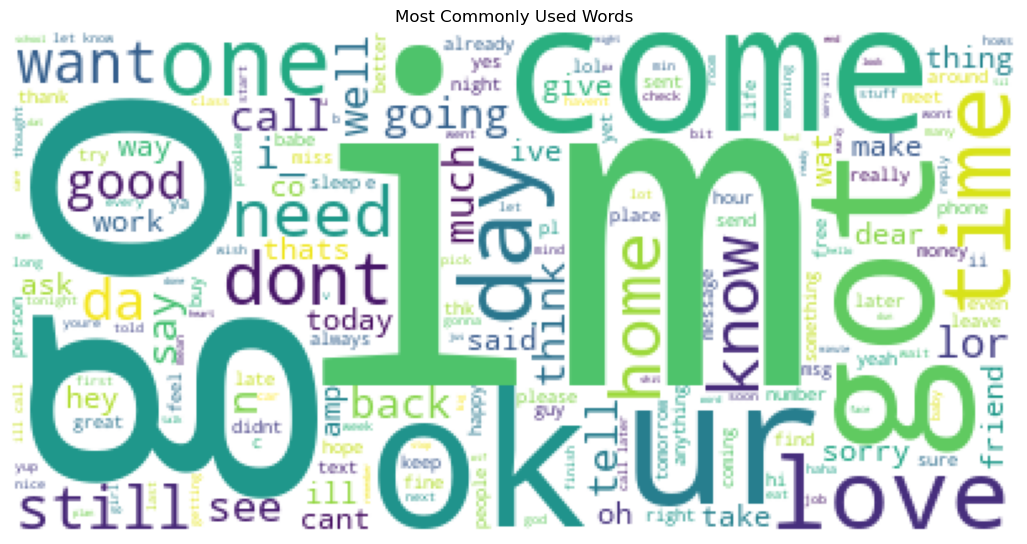

In [45]:
plt.imshow(img)
plt.axis('off')
plt.title('Most Commonly Used Words')
plt.show()

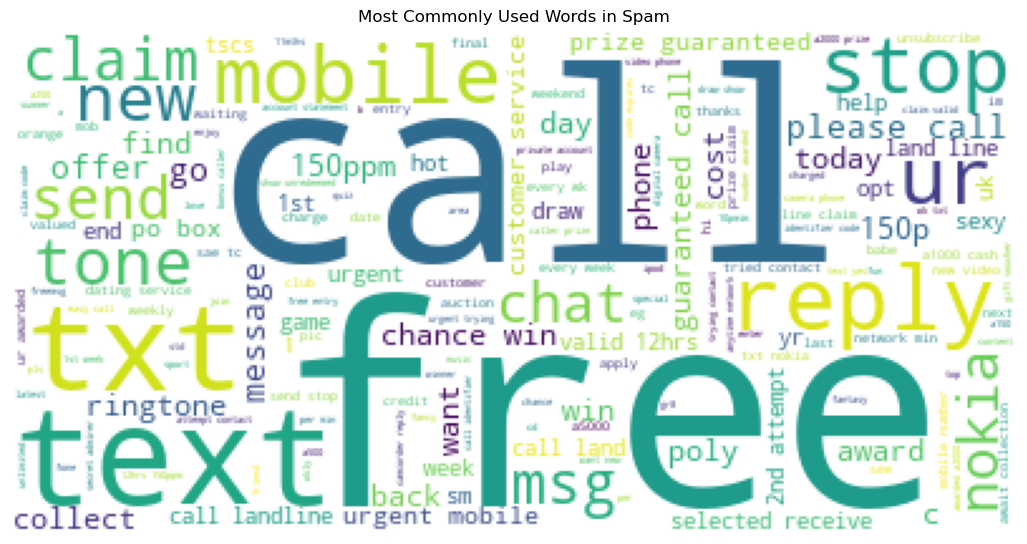

In [46]:
img = WordCloud(background_color='White', ).generate(' '.join(spam_words))
plt.imshow(img)
plt.axis('off')
plt.title('Most Commonly Used Words in Spam')
plt.show()

In [48]:
bigrams = [thing[0] + '_' + thing[1] for thing in nltk.bigrams(ham_words)]

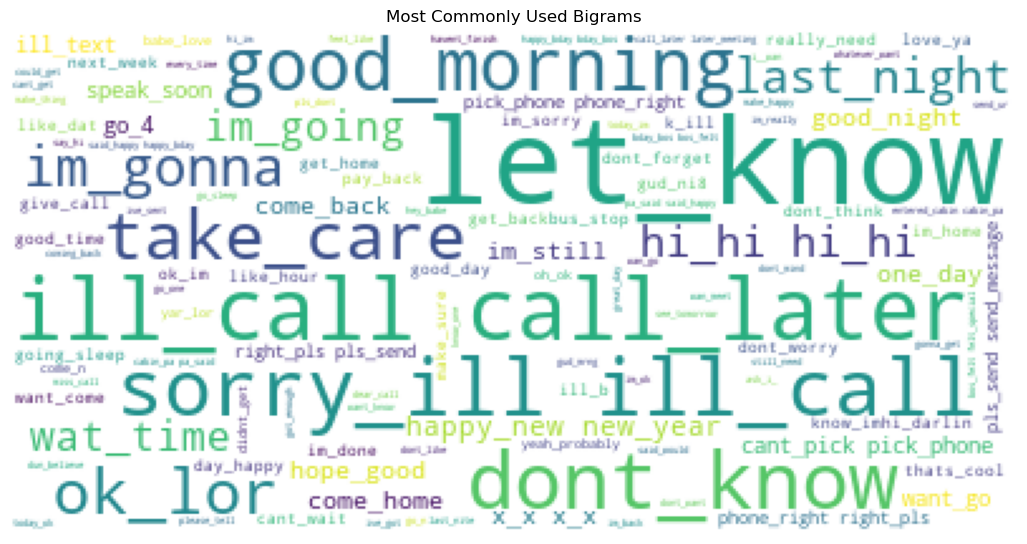

In [49]:
img = WordCloud(background_color='White', ).generate(' '.join(bigrams))
plt.imshow(img)
plt.axis('off')
plt.title('Most Commonly Used Bigrams')
plt.show()

## Other Common Features

Any NLP dataset will have domain specific features, for example: number of retweets, number of @mentions, number of upvotes, or mean time to respond to a support chat. In addition to these domain specific features, some common measures for a document are:

- character count
- word count
- sentence count
- stopword count
- unique word count
- punctuation count
- average word length
- average words per sentence
- word to stopword ratio

Create one or more of the above features and visualize it.

In [ ]:
# we apply our clean function, apply len chained on it
# if we did not want to clean this before
# word count, we would want to do a split on it


## Sentiment

A number indicating whether the document is positive or negative.

- knowledge-based + statistical approach
- relies on human-labelled data
    - combination of qualitative and quantitative methods
    - then empirically validate
- different models for diff domains (e.g. social media vs news)
- for social media
    - Afinn ([github](https://github.com/fnielsen/afinn) + [whitepaper](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf))
    - Vader ([github](https://github.com/cjhutto/vaderSentiment) + [whitepaper](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)) `nltk.sentiment.vader.SentimentIntensityAnalyzer`. Pre-trained sentiment analyzer (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner).)


From your terminal:
`python -c 'import nltk;nltk.download("vader_lexicon")'`

In [50]:
import nltk.sentiment

In [51]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [52]:
sia.polarity_scores('Things are going really really great!')

{'neg': 0.0, 'neu': 0.502, 'pos': 0.498, 'compound': 0.7152}

In [53]:
sia.polarity_scores('Everything sucks!')

{'neg': 0.736, 'neu': 0.264, 'pos': 0.0, 'compound': -0.4199}

In [54]:
sia.polarity_scores('😍')

{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

In [56]:
train['compound_sentiment'] = train['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

,id,label,text,compound_sentiment
4803,4803,ham,"Er, hello, things didnÛ÷t quite go to plan ÛÒ is limping slowly home followed by aa ...",-0.2960
4345,4345,ham,You still around? I could use a half-8th,0.0000
4218,4218,ham,Anything lor if they all go then i go lor...,0.0000
1876,1876,ham,Watching tv now. I got new job :),0.4588
4052,4052,ham,I was slept that time.you there?,0.0000
...,...,...,...,...
3110,3110,ham,Short But Cute : \ Be a good person,0.8338
1723,1723,ham,"Hi Jon, Pete here, Ive bin 2 Spain recently & hav sum dinero left, Bill said u or ur å...",0.4019
5060,5060,ham,"Sorry, I'll call you later. I am in meeting sir.",-0.0772
5167,5167,ham,Oh did you charge camera,0.0000


Things that can influence Sentiment Score:
1. Punctuations. Can increase the intensity
2. Capitalization. Can increase the intensity
3. Degree modifiers
4. Conjunctions

It can handle Emojis and slangs

Apply this to the text message data

In [ ]:
# grab the sentiment from each of the texts as they stand:
# apply a lambda function on each cell in the text column:
# polarity_score's value associtated with the "compound"
# key for each score


In [58]:
# is the mean and median values of sentiment score different for ham vs spam?
train.groupby('label')['compound_sentiment'].mean()

label
ham     0.148131
spam    0.454145
Name: compound_sentiment, dtype: float64

In [ ]:
#plot message_length vs sentiment and hue by label


### Takeaways:
 - Spam messages seem to have roughly the same message length, where ham varies a lot.
 - Spam messages have a very positive sentiment
 - If we wanted to utilize these features for modeling, we would want to proceed forward with means testing to establish their viability

## More Resources

- [kaggle wikipedia movie plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)
    - Suggestion: narrow to top n genres that aren't unknown
- [wikitable extractor](https://wikitable2csv.ggor.de/) (Try with, e.g. [helicopter prison escapes](https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes))
- [Textblob library](https://textblob.readthedocs.io/en/dev/)